In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from smartenergy.database import HourlyMeasurements, HourlyPredictions

from IPython.core.display import display, HTML
from jupyterthemes import jtplot
jtplot.style('onedork')

np.warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
display(HTML("<style>.container { width: 1480px !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%time
hourly_measurements = HourlyMeasurements()
stations = hourly_measurements.station_ids
data = hourly_measurements.load().set_index(['solbox_id', 'datetime'])

CPU times: user 1.52 s, sys: 323 ms, total: 1.84 s
Wall time: 1.94 s


In [3]:
print(data.shape)
data.head()

(44462, 19)


day  fBuyPrice  fIExcess_avg  fILoadDirect_avg  \
solbox_id datetime                                                              
190       2018-01-28 11:00:00   28       1.92          0.79            763.10   
          2018-02-02 12:00:00    2       1.92          0.29            134.40   
          2018-02-02 16:00:00    2       1.92          0.38            135.25   
          2018-02-02 17:00:00    2       1.92          0.29            344.26   
          2018-02-02 18:00:00    2       1.92          0.29            583.20   

                               fILoad_avg  fIPV_avg  fIToBat_avg  \
solbox_id datetime                                                 
190       2018-01-28 11:00:00     2533.30   1142.58         0.00   
          2018-02-02 12:00:00     1946.26   1514.66       281.39   
          2018-02-02 16:00:00     1951.17   1190.97       -45.62   
          2018-02-02 17:00:00     2166.99   1159.90      -243.32   
          2018-02-02 18:00:00     2415.47   1155.39      -462.41   

                               fIToGrid_avg  fSellPrice  fTemperature_avg  \
solbox_id datetime                                                          
190       2018-01-28 11:00:00          0.00        1.20             23.75   
          2018-02-02 12:00:00        -12.56        1.20             22.28   
          2018-02-02 16:00:00        -14.15        1.20             24.26   
          2018-02-02 17:00:00        -63.34        1.20             23.87   
          2018-02-02 18:00:00        -97.24        1.20             23.40   

                               hour  month  u32TotalBought  u32TotalSold  \
solbox_id datetime                                                         
190       2018-01-28 11:00:00    11      1            0.00         54.00   
          2018-02-02 12:00:00    12      2            0.00         43.00   
          2018-02-02 16:00:00    16      2            0.00         43.00   
          2018-02-02 17:00:00    17      2            1.15         43.00   
          2018-02-02 18:00:00    18      2           14.17         43.00   

                               u8StateOfBattery  u8UserMode  week  weekday  \
solbox_id datetime                                                           
190       2018-01-28 11:00:00              2.00        1.00  4.00     6.00   
          2018-02-02 12:00:00              3.00        0.00  5.00     4.00   
          2018-02-02 16:00:00              3.00        2.00  5.00     4.00   
          2018-02-02 17:00:00              3.00        2.00  5.00     4.00   
          2018-02-02 18:00:00              3.00        2.00  5.00     4.00   

                               year  
solbox_id datetime                   
190       2018-01-28 11:00:00  2018  
          2018-02-02 12:00:00  2018  
          2018-02-02 16:00:00  2018  
          2018-02-02 17:00:00  2018  
          2018-02-02 18:00:00  2018

## Modelling

In [4]:
### Create features
model_matrix = data.copy().sort_index()

features_to_lag = ['fILoadDirect_avg', 'fILoad_avg', 'fIPV_avg', 'fIExcess_avg', 'fIToGrid_avg', 
                   'fIToBat_avg', 'fTemperature_avg', 'u8StateOfBattery']
common_features = ['year', 'month', 'day', 'hour', 'weekday', 'fBuyPrice', 'fSellPrice']

lags = 12

for lag in range(1, lags+1):
    colnames = ['{}_lag_{}'.format(f, lag) for f in features_to_lag]
    model_matrix[colnames] = model_matrix.groupby('solbox_id')[features_to_lag].shift(lag).fillna(0)

lagged_features = colnames = ['{}_lag_{}'.format(f, lag) for f in features_to_lag for lag in range(1, lags+1)]    

model_matrix_pivoted = pd.pivot_table(model_matrix[lagged_features+features_to_lag], columns='solbox_id', index='datetime')
features_pivoted = ['_station'.join(col).strip() for col in model_matrix_pivoted.columns.values]
lagged_features_pivoted = [col for col in features_pivoted if 'lag' in col]
model_matrix_pivoted.columns = features_pivoted
model_matrix = model_matrix.reset_index().set_index('datetime').drop_duplicates()
model_matrix = model_matrix[common_features].join(model_matrix_pivoted)
print(model_matrix.shape)
model_matrix.head()

(44462, 1775)


year  month  day  hour  weekday  fBuyPrice  fSellPrice  \
datetime                                                                      
2017-10-30 06:00:00  2017     10   30     6     0.00       1.92        1.20   
2017-10-30 06:00:00  2017     10   30     6     0.00       1.92        1.20   
2017-10-30 06:00:00  2017     10   30     6     0.00       1.92        1.20   
2017-10-30 06:00:00  2017     10   30     6     0.00       1.92        1.20   
2017-10-30 06:00:00  2017     10   30     6     0.00       1.92        1.20   

                     fIExcess_avg_station190  fIExcess_avg_station30  \
datetime                                                               
2017-10-30 06:00:00                      nan                    0.29   
2017-10-30 06:00:00                      nan                    0.29   
2017-10-30 06:00:00                      nan                    0.29   
2017-10-30 06:00:00                      nan                    0.29   
2017-10-30 06:00:00                      nan                    0.29   

                     fIExcess_avg_station309  \
datetime                                       
2017-10-30 06:00:00                      nan   
2017-10-30 06:00:00                      nan   
2017-10-30 06:00:00                      nan   
2017-10-30 06:00:00                      nan   
2017-10-30 06:00:00                      nan   

                                   ...                 \
datetime                           ...                  
2017-10-30 06:00:00                ...                  
2017-10-30 06:00:00                ...                  
2017-10-30 06:00:00                ...                  
2017-10-30 06:00:00                ...                  
2017-10-30 06:00:00                ...                  

                     u8StateOfBattery_lag_9_station366  \
datetime                                                 
2017-10-30 06:00:00                                nan   
2017-10-30 06:00:00                                nan   
2017-10-30 06:00:00                                nan   
2017-10-30 06:00:00                                nan   
2017-10-30 06:00:00                                nan   

                     u8StateOfBattery_lag_9_station369  \
datetime                                                 
2017-10-30 06:00:00                                nan   
2017-10-30 06:00:00                                nan   
2017-10-30 06:00:00                                nan   
2017-10-30 06:00:00                                nan   
2017-10-30 06:00:00                                nan   

                     u8StateOfBattery_lag_9_station37  \
datetime                                                
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   

                     u8StateOfBattery_lag_9_station40  \
datetime                                                
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   

                     u8StateOfBattery_lag_9_station43  \
datetime                                                
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                              0.00   

                     u8StateOfBattery_lag_9_station47  \
datetime                                                
2017-10-30 06:00:00                              0.00   
2017-10-30 06:00:00                     

In [5]:
%%time
## Analize model fit
from xgboost import XGBRegressor
from random import choice


features = lagged_features_pivoted + common_features
target = 'fILoadDirect_avg'
station = choice(stations)
target_station = target+'_station{}'.format(station)

X, Y = model_matrix.dropna(subset=[target_station])[features], model_matrix.dropna(subset=[target_station])[target_station]
print(X.shape)
print('Fitting model for station {}'.format(station))
xgb = XGBRegressor()
xgb.fit(X, Y)

(7590, 1639)
Fitting model for station 369
CPU times: user 43.7 s, sys: 1.33 s, total: 45 s
Wall time: 45.4 s


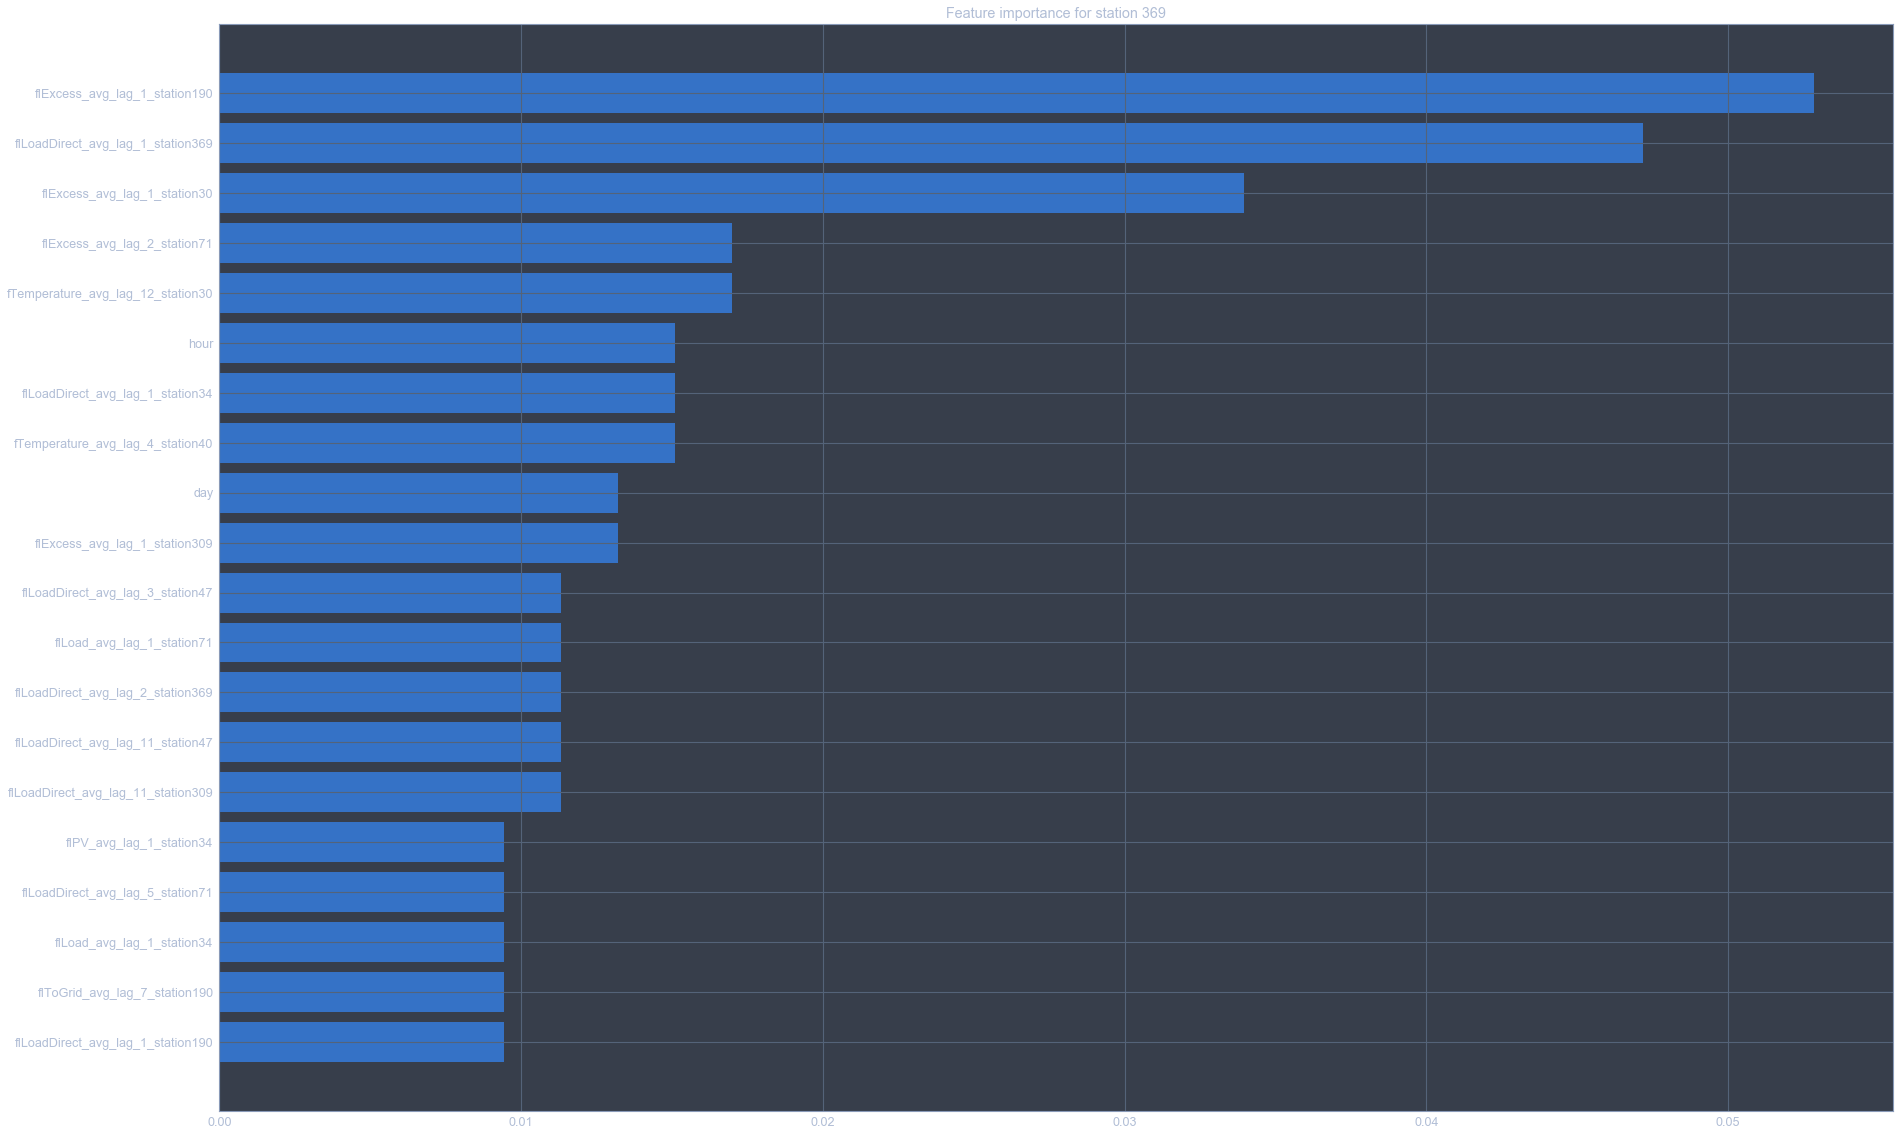

In [6]:
feature_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
important_features = feature_importance[:20][::-1]
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111)
ax.barh(important_features.keys(), important_features.values, align='center')
plt.title('Feature importance for station {}'.format(station))
plt.show()

In [ ]:
def n_steps_ahead(data, min_records, n=1):
    return ((range(i), i+n) for i in range(min_records, len(data)-1))

hourly_predictions = HourlyPredictions()
hourly_predictions.drop()

loss_function = lambda x, y: (x - y)**2
losses = list()
for station in stations:
    target_station = target+'_station{}'.format(station)
    X, Y = model_matrix.dropna(subset=[target_station])[features], model_matrix.dropna(subset=[target_station])[target_station]
    min_records = int(len(X)*2/3)
    assert len(X) > min_records, 'Length of data is lower than min_records'
    n = 1
    xgb = XGBRegressor()
    xgb.fit(X.iloc[:min_records], Y.iloc[:min_records])
    print('Model successfully fitted for station {}'.format(station))
    losses_station = list()
    for train_ix, test_ix in n_steps_ahead(X, min_records, n):
        prediction = xgb.predict(X.iloc[[test_ix]])[0].astype(float) # Double brackets to keep it a DataFrame
        hourly_predictions.store(
            xgb.__class__.__name__,
            target,
            station,
            X.iloc[[test_ix]].index[0],
            prediction,
            Y.iloc[[test_ix]].values[0]
        )
        loss = loss_function(prediction, Y.iloc[[test_ix]].values[0]) / np.mean(Y)
        losses_station.append(loss)
    print('Loss for station {}: {}'.format(station, np.mean(losses_station)))
    losses.append(losses_station)


Model successfully fitted for station 190
Loss for station 190: 15.481273531959719
Model successfully fitted for station 30
Loss for station 30: 0.021383012402067556
Model successfully fitted for station 309
Loss for station 309: 0.2299702436565808
Model successfully fitted for station 32
Loss for station 32: 29.84347037431153
Model successfully fitted for station 34
Loss for station 34: 0.060163847410101466
Model successfully fitted for station 344
Loss for station 344: 0.03830310176742598
Model successfully fitted for station 345
Loss for station 345: 22.67346139588333
Model successfully fitted for station 366
Loss for station 366: 187.95998411529263
Model successfully fitted for station 369
Loss for station 369: 0.047178637188126565
Model successfully fitted for station 37
Loss for station 37: 0.020437442871325782
Model successfully fitted for station 40
Loss for station 40: 0.015759134985365266
Model successfully fitted for station 43
Loss for station 43: 182.27105790428254
Model s

In [273]:
predictions = load_predictions(db.hourly_predictions)

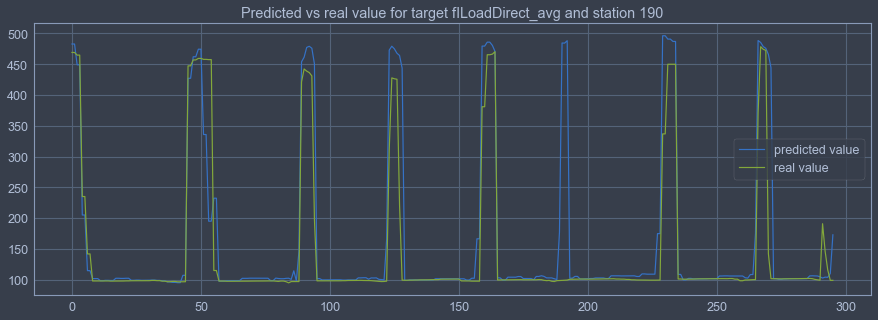

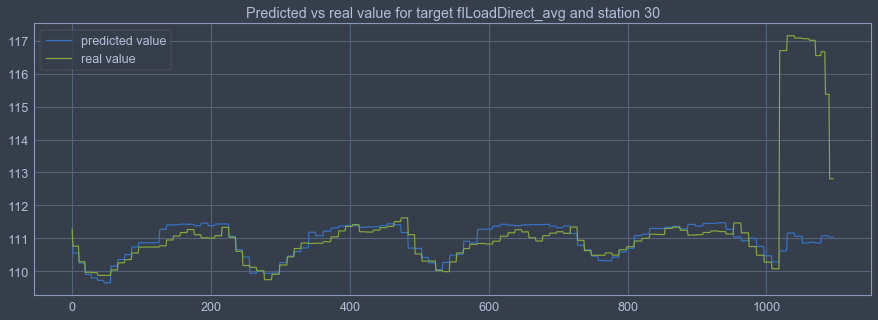

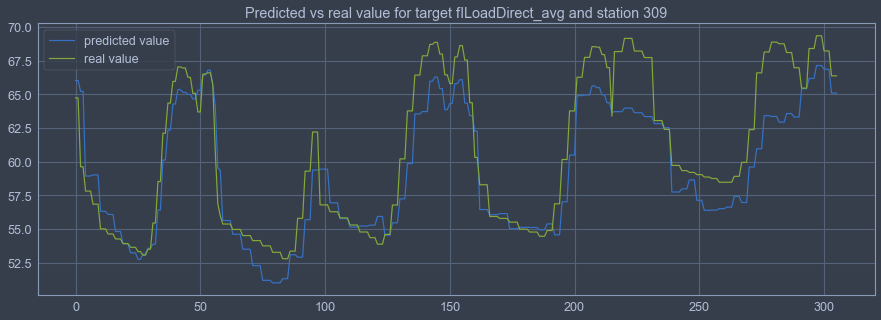

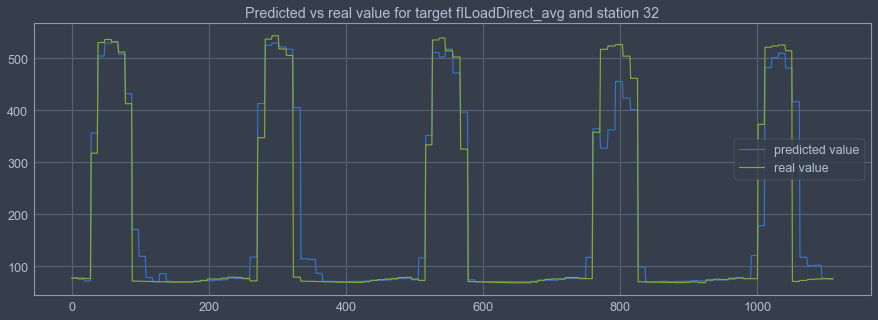

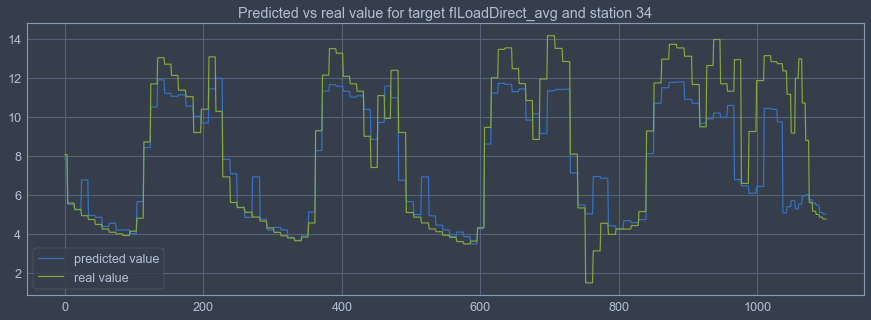

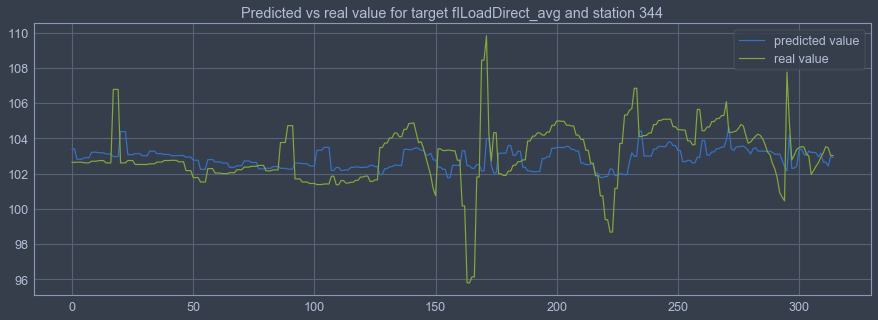

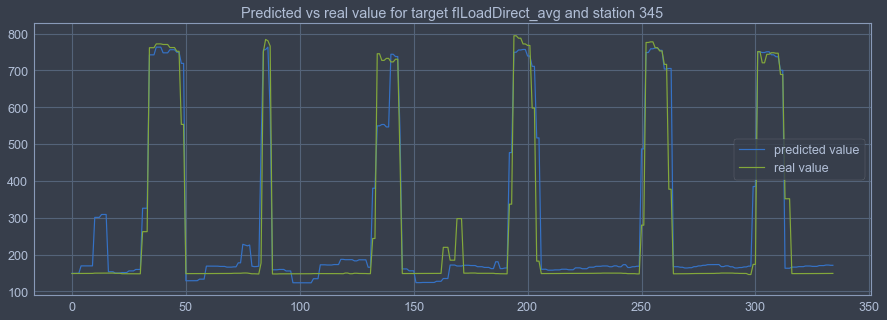

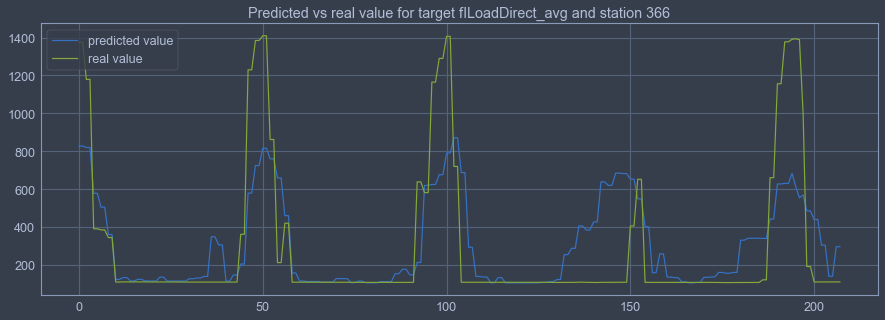

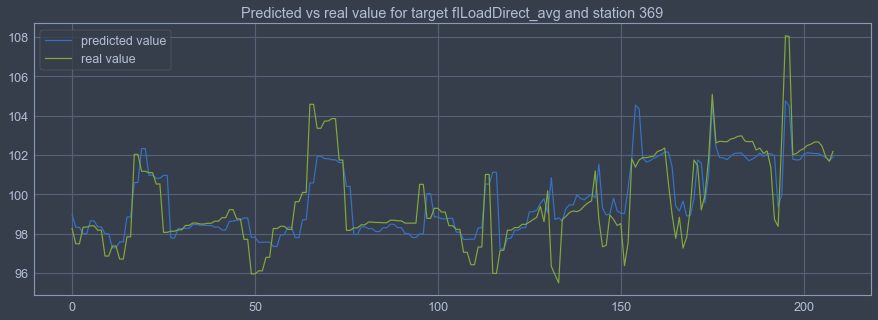

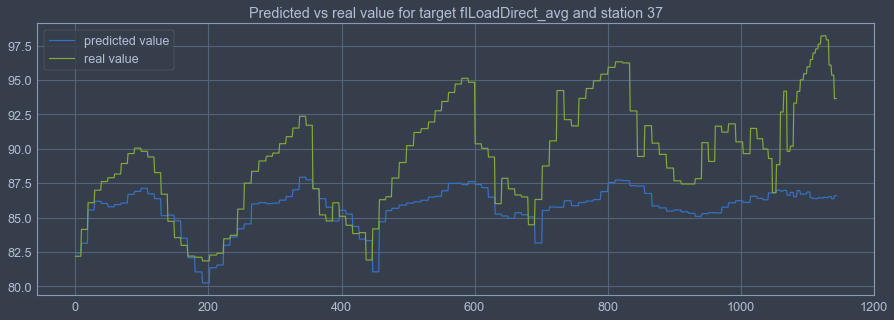

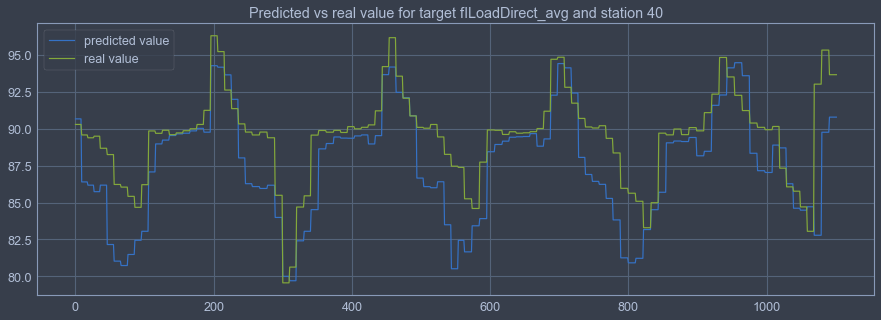

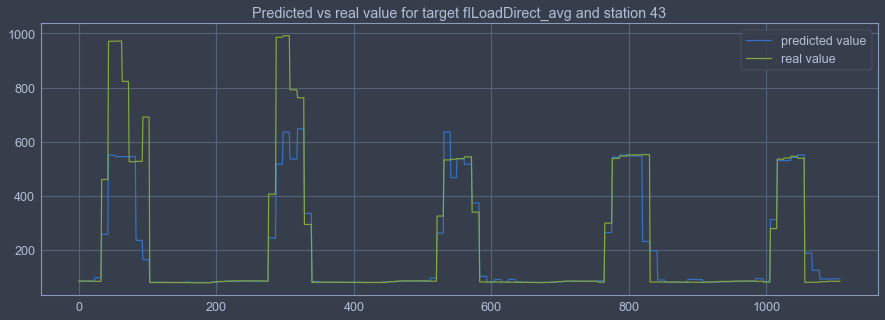

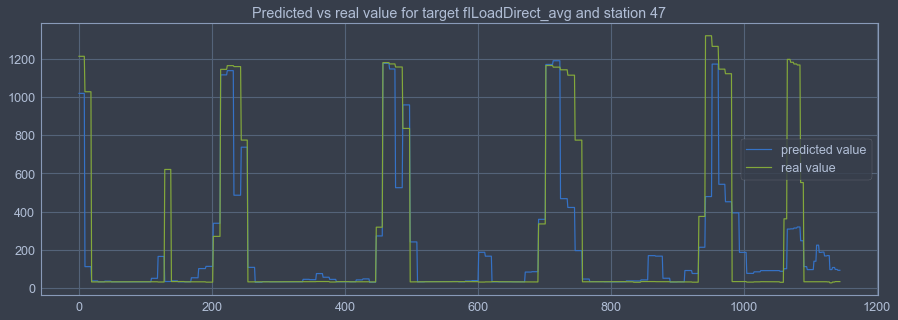

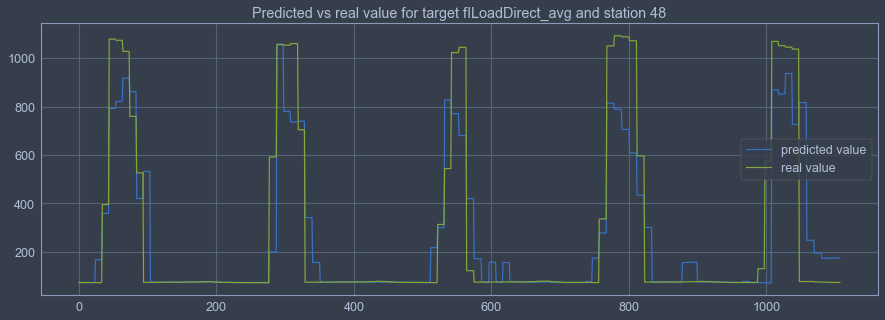

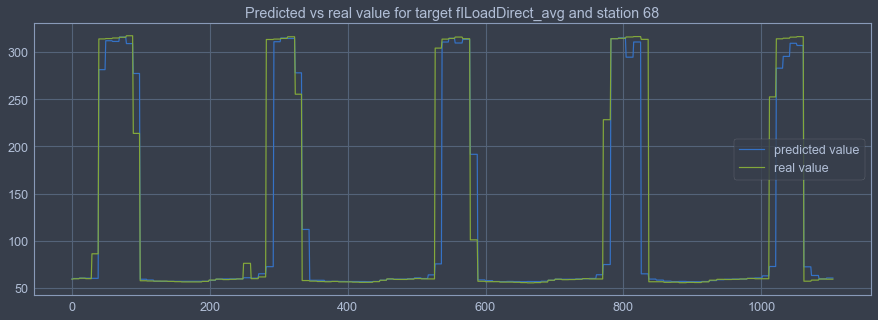

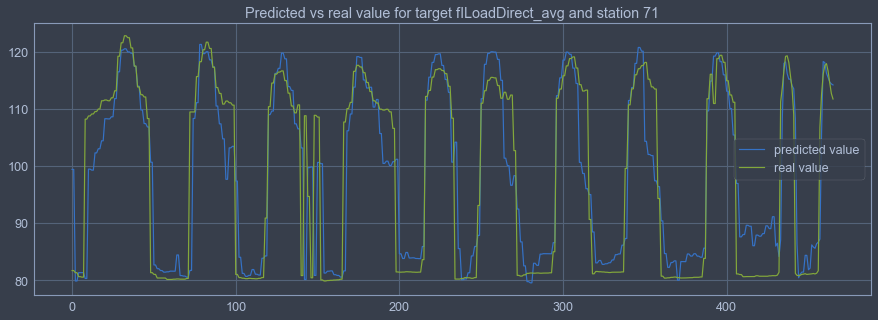

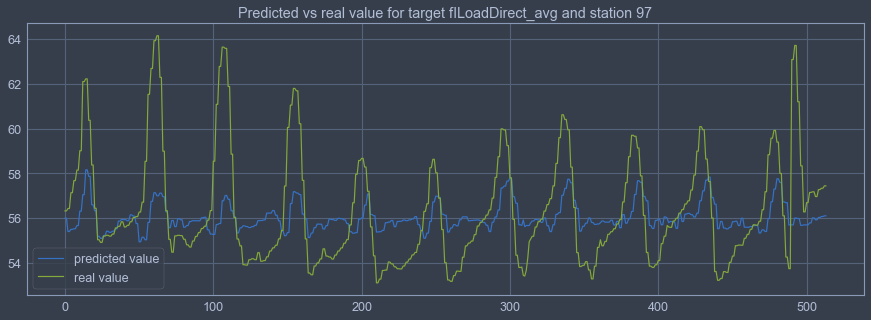

In [274]:
for station in stations:
    plt.figure(figsize=(15, 5))
    plt.plot(predictions.loc[station, 'prediction'].values, label='predicted value')
    plt.plot(predictions.loc[station, 'ground_truth'].values, label='real value')
        
    plt.title('Predicted vs real value for target {} and station {}'.format(target, station))
    plt.legend()
    plt.show()